# The aim of this notebook is to create a model that predicts the size of a wildfire

Author: Marcelo Garcia Escalante

In [1]:
# All imports for the project goes here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from helpers import feature_plot
from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce

%matplotlib inline
%load_ext autoreload
%autoreload 2

## EDA (Exploratory Data Analysis)

In this section, we will visualize and analyze our dataset. Also any possible clean-up required will be performed. 

In [2]:
# Loading the dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.dtypes

fire_number                      object
fire_year                         int64
assessment_datetime              object
size_class                       object
fire_location_latitude          float64
fire_location_longitude         float64
fire_origin                      object
general_cause_desc               object
activity_class                   object
true_cause                       object
fire_start_date                  object
det_agent_type                   object
det_agent                        object
discovered_date                  object
reported_date                    object
start_for_fire_date              object
fire_fighting_start_date         object
initial_action_by                object
fire_type                        object
fire_position_on_slope           object
weather_conditions_over_fire     object
fuel_type                        object
bh_fs_date                       object
uc_fs_date                       object
ex_fs_date                       object


`note:` We can see that most of our data is categorical with two of the features being float numbers and one an integer

In [4]:
#Visualizing the train dataset
train.tail()

,fire_number,fire_year,assessment_datetime,size_class,fire_location_latitude,fire_location_longitude,fire_origin,general_cause_desc,activity_class,true_cause,...,start_for_fire_date,fire_fighting_start_date,initial_action_by,fire_type,fire_position_on_slope,weather_conditions_over_fire,fuel_type,bh_fs_date,uc_fs_date,ex_fs_date
15870,SWF001,2006,2006-04-07 17:55:00,B,55.355664,-115.776846,Indian Reservation,Incendiary,Lighting Fires,Arson Known,...,2006-04-07 18:00:00,NaN,Fire Department,Surface,Flat,Clear,O1a,2006-04-07 17:55:00,2006-04-07 17:55:00,2006-04-07 19:30:00
15871,HWF091,2008,2008-06-03 15:35:00,A,58.743900,-117.223467,Provincial Land,Lightning,NaN,NaN,...,2008-06-03 15:08:00,2008-06-03 16:00:00,HAC1F,Ground,Flat,Clear,C2,2008-06-03 16:42:00,2008-06-03 16:42:00,2008-06-03 18:24:00
15872,HWF234,2015,2015-06-26 15:27:00,E,59.846600,-116.768133,Provincial Land,Lightning,NaN,NaN,...,2015-06-26 17:30:00,2015-06-26 17:30:00,FTAC,Ground,Flat,CB Wet,C1,2015-06-26 22:00:00,2015-06-26 23:00:00,2015-07-01 10:46:00
15873,MWF097,2008,2008-07-19 14:59:00,A,56.300000,-112.535217,Provincial Land,Lightning,NaN,NaN,...,2008-07-19 14:55:00,2008-07-19 15:10:00,HAC1H,Surface,Flat,Cloudy,C2,2008-07-19 15:20:00,2008-07-19 15:30:00,2008-07-19 17:43:00
15874,SWF133,2015,2015-06-26 17:05:00,B,55.917023,-113.707167,Private Land,Resident,Debris Disposal,Unsafe Fire,...,2015-06-26 16:51:00,2015-06-26 17:25:00,HAC,Surface,Flat,Clear,M2,2015-06-26 17:52:00,2015-06-26 19:35:00,2015-06-27 16:40:00


In [5]:
#Visualizing the test dataset
test.tail()

,fire_number,fire_year,assessment_datetime,fire_location_latitude,fire_location_longitude,fire_origin,general_cause_desc,activity_class,true_cause,fire_start_date,...,start_for_fire_date,fire_fighting_start_date,initial_action_by,fire_type,fire_position_on_slope,weather_conditions_over_fire,fuel_type,bh_fs_date,uc_fs_date,ex_fs_date
3964,RWF047,2018,2018-07-30 17:21:00,52.490550,-115.964300,Provincial Land,Lightning,NaN,NaN,2018-07-30 16:30:00,...,2018-07-30 17:21:00,2018-07-30 17:42:00,HAC,Surface,Flat,Rainshowers,C3,2018-07-30 17:21:00,2018-07-30 17:50:00,2018-07-30 18:05:00
3965,GWF067,2009,2009-06-27 19:30:00,55.077350,-117.618717,Private Land,Resident,Refuse,Permit Related,2009-06-26 16:00:00,...,2009-06-27 19:00:00,NaN,Land Owner,Surface,Bottom,Cloudy,NaN,2009-06-27 19:30:00,2009-06-27 19:30:00,2009-06-30 14:30:00
3966,GWF194,2006,2006-09-07 14:35:00,54.350328,-119.919998,Provincial Land,Restart,NaN,NaN,2006-09-01 16:00:00,...,2006-09-07 14:51:00,2006-09-07 15:35:00,HAC1F,Ground,Upper 1/3,Clear,C3,2006-09-07 14:35:00,2006-09-07 14:35:00,2006-09-27 16:50:00
3967,LWF091,2012,2012-06-01 16:10:00,55.105667,-111.517000,Provincial Land,Recreation,Transportation,Vehicle Fire,2012-06-01 15:32:00,...,2012-06-01 15:38:00,NaN,Fire Department,Surface,Bottom,Clear,O1a,2012-06-01 16:10:00,2012-06-01 16:10:00,2012-06-01 16:24:00
3968,GWF084,2008,2008-07-09 09:26:00,55.035717,-117.867233,Private Land,Resident,Unclassified,Unpredictable Event,2008-07-08 21:00:00,...,2008-07-09 08:28:00,NaN,Fire Department,Surface,Flat,Clear,NaN,2008-07-09 09:26:00,2008-07-09 09:26:00,2008-07-15 10:40:00


In [6]:
# Shape of dataset
print(f"The shape of train dataset is: {train.shape}")
print(f"The shape of test dataset is: {test.shape}")

The shape of train dataset is: (15875, 25)
The shape of test dataset is: (3969, 24)


`comment:` First thing we can notice is that the features are not the same. Train has 25 features while test has only 24. let's see what is the difference

In [7]:
train.columns[np.array([feature not in test.columns for feature in train.columns])][0]

'size_class'

That will mean that our testing dataset does not have labels. The reason for this is that this is a contest and the labels are not provided as this will be the metric to assess the performance of all the models proposed by each contestant. 

`size_class` is the target we want to predict with our model. Let's visualize what are the possible outcomes of this feature:


In [8]:
classes = list(train['size_class'].unique())
print(f"The possible classes in the target feature are: {classes}")

The possible classes in the target feature are: ['A', 'B', 'D', 'E', 'C']


That will mean that we have 5 classes to predict. In fact in the dataset information we can find that these classes represent ranges to which the wildfire grows until the final aree burned is determined after extinghishment. The area is catalogized as follows: 

* **A:** 0 to 0.1 [ha]
* **B:** 0.1 to 4 [ha]
* **C:** 4 to 40 [ha]
* **D:** 40 to 200 [ha]
* **E:** more than 200 [ha]

`note:` all sizes are in hectare(ha). $$ 1 ha = 10000 m^2 $$

### Clean data

In this section we will look for empty or null values that could make invalid our analysis

In [9]:
null_counts = train.isnull().sum()
null_counts[null_counts > 0].sort_values(ascending=False)

true_cause                      7194
activity_class                  6197
fuel_type                       4793
fire_fighting_start_date        4199
discovered_date                 2119
weather_conditions_over_fire    1893
fire_position_on_slope          1888
fire_type                       1819
fire_start_date                  433
fire_origin                        7
reported_date                      1
det_agent                          1
det_agent_type                     1
dtype: int64

In [10]:
null_counts = test.isnull().sum()
null_counts[null_counts > 0].sort_values(ascending=False)

true_cause                      1796
activity_class                  1524
fuel_type                       1247
fire_fighting_start_date        1080
discovered_date                  546
weather_conditions_over_fire     456
fire_position_on_slope           456
fire_type                        434
fire_start_date                  112
fire_origin                        3
dtype: int64

`comment:` From above we can see that most of the missing data for both datasets are in the `true_cause` and `activity class` features, which means that we don't know what was the true reason of the wildfire or what was the activity that was going on when the wildfire was started. 

In [11]:
pd.set_option('display.max_columns', None)
print(f"Number of datapoints that have at least one value missing: {len(train[train.isnull().any(axis=1)])}")

Number of datapoints that have at least one value missing: 14137


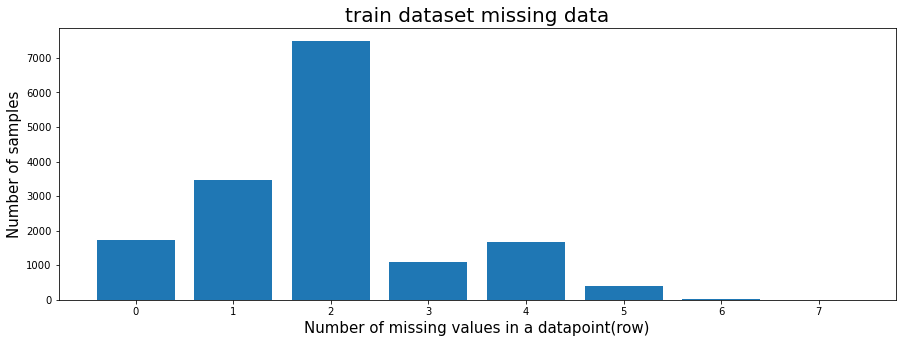

In [12]:
plt.figure(figsize=(15,5))
plt.bar(*zip(*dict(Counter(train.isnull().sum(axis=1))).items()))
plt.xlabel('Number of missing values in a datapoint(row)', fontsize=15)
plt.ylabel('Number of samples', fontsize=15)
plt.title('train dataset missing data', fontsize=20)
plt.show()

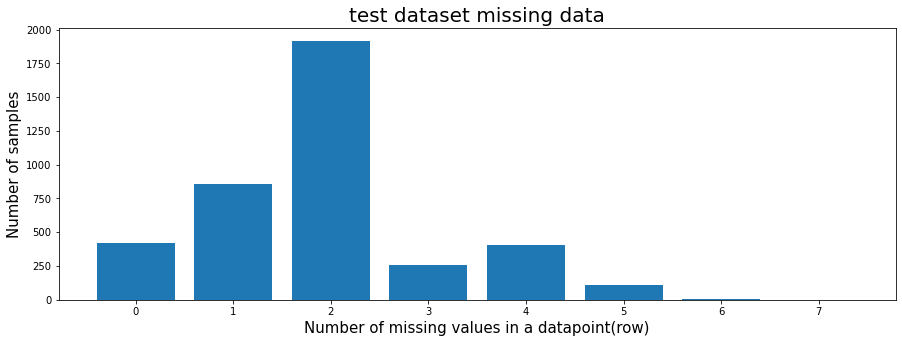

In [13]:
plt.figure(figsize=(15,5))
plt.bar(*zip(*dict(Counter(test.isnull().sum(axis=1))).items()))
plt.xlabel('Number of missing values in a datapoint(row)', fontsize=15)
plt.ylabel('Number of samples', fontsize=15)
plt.title('test dataset missing data', fontsize=20)
plt.show()

`comment:` We can see from above that in most of our data 2 missing features are common followed by one missing feature per row. Most likely `true_cause` and `activity class` as they are the most frequent missing feature. That means that perhaps it is not a good idea to trust in this features for building our model.

#### Cleaning data
Since all of the features that contain null values are categorical, we will proceed to change the `NaN` to `unknown`

In [14]:
train = train.fillna('Unknown')
test = test.fillna('Unknown')


### Visualize class distribution
Lets visualize data distribution grouped by class of the target feature after the clean up

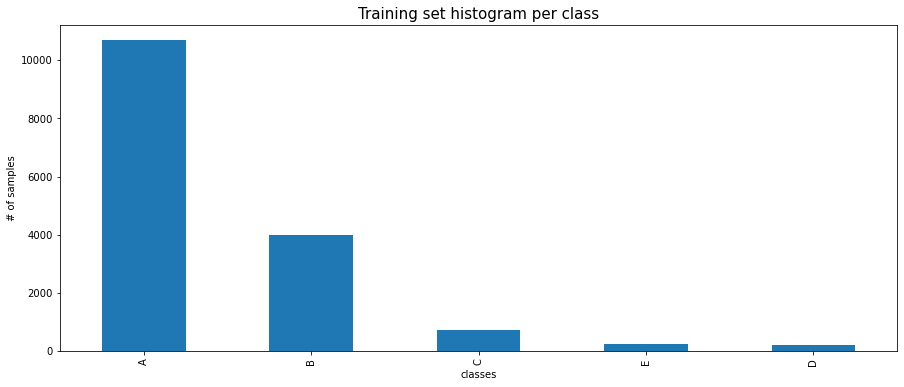

In [15]:
plt.figure(figsize=(15,6))
train['size_class'].value_counts().plot(kind='bar');
plt.title('Training set histogram per class', fontsize=15);
plt.xlabel('classes')
plt.ylabel('# of samples');

In [16]:
train['size_class'].value_counts()

A    10679
B     4000
C      734
E      246
D      216
Name: size_class, dtype: int64

From plot above, we can notice that we have an unbalanced number of classes. Therefore, we must be very cautious to not make our model skew towards the classes with more data


## Build Model

In this section we will build a model to classify `size_class` of our dataset.

### One Hot encode categorical data


In [22]:
y_train = train[['size_class']][0:200]
X_train = train.drop('size_class', 1)[0:200]

ohe = ce.OneHotEncoder(handle_unknown='value', use_cat_names=True)
X_train_ohe = ohe.fit_transform(X_train)
X_train_ohe

fire_number_CWF142  fire_number_HWF060  fire_number_HWF140  \
0                     1                   0                   0   
1                     0                   1                   0   
2                     0                   0                   1   
3                     0                   0                   0   
4                     0                   0                   0   
..                  ...                 ...                 ...   
195                   0                   0                   0   
196                   0                   0                   0   
197                   0                   0                   0   
198                   0                   0                   0   
199                   0                   0                   0   

     fire_number_CWF098  fire_number_SWF001  fire_number_SWF038  \
0                     0                   0                   0   
1                     0                   0                   0   
2                     0                   0                   0   
3                     1                   0                   0   
4                     0                   1                   0   
..                  ...                 ...                 ...   
195                   0                   0                   0   
196                   0                   0                   0   
197                   0                   0                   0   
198                   0                   0                   0   
199                   0                   0                   0   

     fire_number_MWF020  fire_number_PWF135  fire_number_PWF090  \
0                     0                   0                   0   
1                     0                   0                   0   
2                     0                   0                   0   
3                     0                   0                   0   
4                     0                   0                   0   
..                  ...                 ...                 ...   
195                   0                   0                   0   
196                   0                   0                   0   
197                   0                   0                   0   
198                   0                   0                   0   
199                   0                   0                   0   

     fire_number_PWF019  fire_number_SWF132  fire_number_SWF141  \
0                     0                   0                   0   
1                     0                   0                   0   
2                     0                   0                   0   
3                     0                   0                   0   
4                     0                   0                   0   
..                  ...                 ...                 ...   
195                   0                   0                   0   
196                   0                   0                   0   
197                   0                   0                   0   
198                   0                   0                   0   
199                   0                   0                   0   

     fire_number_CWF045  fire_number_CWF056  fire_number_HWF069  \
0                     0                   0                   0   
1                     0                   0                   0   
2                     0                   0                   0   
3                     0                   0                   0   
4                     0                   0                   0   
..                  ...                 ...                 ...   
195                   0                   0                   0   
196                   0                   0                   0   
197                   0                   0                   0   
198                   0                   0                   0   
199                   0                   0     

### Define most important features

In all datasets there is always a high chance that some features are irrelevant to predict the target feature. We could try guessing which ones are the most relevant using our intuition. However, intuition is not always good. Therefore, there is an alternative way to do it using feature importances that is available for tree based models in Sklearn. To quickly identify some of the features let's use a simple random forest classifier.

In [ ]:
model = RandomForestClassifier()
model.fit(X_train, y_train)

# TODO: Extract the feature importances using .feature_importances_ 
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

stratified k fold cross validation
https://machinelearningmastery.com/cross-validation-for-imbalanced-classification/

[Oversampling using SMOTE](https://medium.com/lumiata/cross-validation-for-imbalanced-datasets-9d203ba47e8)